# Quanvolutional Neural Networks

In this demo we implement the Quanvolutional Neural Network, a quantum machine learning model originally introduced in Henderson et al. (2019).

![title](img/qnn_circuit.png)

# Classical convolution

The convolutional neural network (CNN) is a standard model in classical machine learning which is particularly suitable for processing images. The model is based on the idea of a convolution layer where, instead of processing the full input data with a global function, a local convolution is applied.

If the input is an image, small local regions are sequentially processed with the same kernel. The results obtained for each region are usually associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers.

# Quantum convolution

One can extend the same idea also to the context of quantum variational circuits. A possible approach is given by the following procedure which is very similar to the one used in Ref. [1]. The scheme is also represented in the figure at the top of this tutorial.

1. A small region of the input image, in our example a 
2
×
2
 square, is embedded into a quantum circuit. In this demo, this is achieved with parametrized rotations applied to the qubits initialized in the ground state.

2. A quantum computation, associated to a unitary 
U
, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a random circuit as proposed in Ref. [1].

3. The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classically post-processed as proposed in Ref. [1] but, for simplicity, in this demo we directly use the raw expectation values.

4. Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.

5. Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

6. The quantum convolution can be followed by further quantum layers or by classical layers.

The main difference with respect to a classical convolution is that a quantum circuit can generate highly complex kernels whose computation could be, at least in principle, classically intractable.

Note

In this tutorial we follow the approach of Ref. [1] in which a fixed non-trainable quantum circuit is used as a “quanvolution” kernel, while the subsequent classical layers are trained for the classification problem of interest. However, by leveraging the ability of PennyLane to evaluate gradients of quantum circuits, the quantum kernel could also be trained.

120


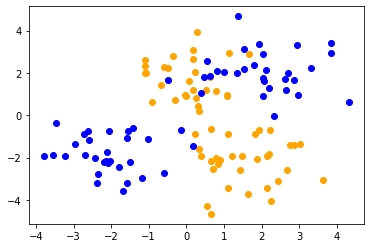

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 30 * 4

A = np.array([[np.random.normal(loc=0), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
B = np.array([[np.random.normal(loc=2), np.random.normal(loc=-2)] for i in range(n_samples//4)]) 
C = np.array([[np.random.normal(loc=2), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
D = np.array([[np.random.normal(loc=-2), np.random.normal(loc=-2)] for i in range(n_samples//4)])

feature = np.concatenate([A, B,C,D], axis=0)/4
label = np.concatenate([-np.ones(n_samples // 2), np.ones(n_samples//2)], axis=0)
data = list(zip(feature, label))

np.random.shuffle(data)
print(len(data))
plt.scatter(A[:,0], A[:,1], color = "orange")
plt.scatter(B[:,0], B[:,1], color = "orange")
plt.scatter(C[:,0], C[:,1], color = "blue")
plt.scatter(D[:,0], D[:,1], color = "blue")
plt.show()

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


Setting of the main hyper-parameters of the model

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

We import the MNIST dataset from Keras. To speedup the evaluation of this demo we use only a small number of training and test images. Obviously, better results are achievable when using the full dataset.

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11501568/11490434 [==============================] - 1s 0us/step


# Quantum circuit as a convolution kernel

We follow the scheme described in the introduction and represented in the figure at the top of this demo.

We initialize a PennyLane default.qubit device, simulating a system of 4 qubits. The associated qnode represents the quantum circuit consisting of:

    1. an embedding layer of local Ry rotations (with angles scaled by a factor of π);

    2. a random circuit of n_layers;

    3. a final measurement in the computational basis, estimating 4 expectation values

In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

    1. the image is divided into squares of 2×2 pixels;

    2. each square is processed by the quantum circuit;
    
    3. the 4  expectation values are mapped into 4  different channels of a single output pixel.

Note

This process halves the resolution of the input image. In the standard language of CNN, this would correspond to a convolution with a 
2
×
2
 kernel and a stride equal to 
2
.

In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [11]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save("img/" + "q_train_images.npy", q_train_images)   ### EDIT THE PATH TO SAVE THE IMAGES
    np.save("img/" + "q_test_images.npy", q_test_images)     ### EDIT THE PATH TO SAVE THE IMAGES


# Load pre-processed images
q_train_images = np.load("img/" + "q_train_images.npy")     ### EDIT THE PATH TO LOAD THE IMAGES
q_test_images = np.load("img/" + "q_test_images.npy")      ### EDIT THE PATH TO LOAD THE IMAGES

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch of samples:

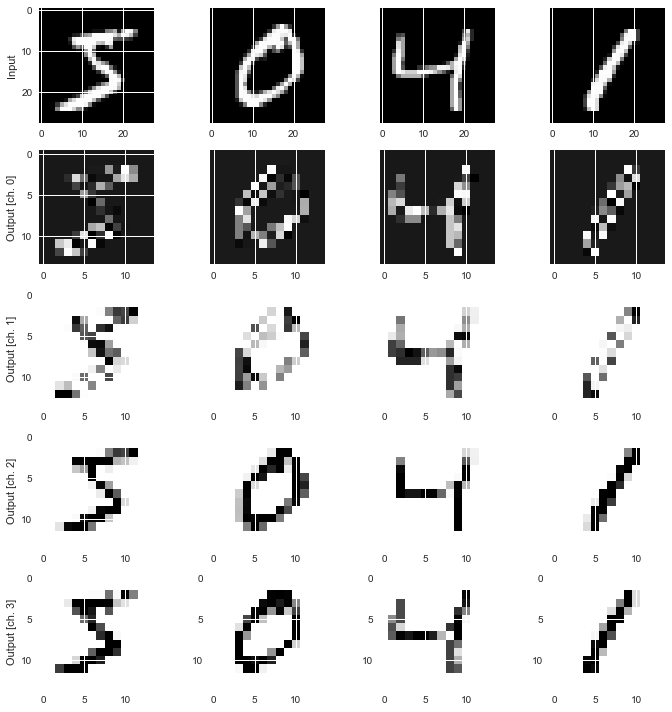

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the 
4
 output channels generated by the quantum convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local distortion introduced by the quantum kernel. On the other hand the global shape of the image is preserved, as expected for a convolution layer.


# Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 
10
 different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [13]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [14]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9351 - accuracy: 0.1000 - val_loss: 2.3946 - val_accuracy: 0.1000 - 758ms/epoch - 58ms/step
Epoch 2/30
13/13 - 0s - loss: 2.1241 - accuracy: 0.2800 - val_loss: 2.1525 - val_accuracy: 0.2000 - 52ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7218 - accuracy: 0.5600 - val_loss: 2.0267 - val_accuracy: 0.3333 - 46ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3012 - accuracy: 0.6400 - val_loss: 1.7713 - val_accuracy: 0.4000 - 43ms/epoch - 3ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0990 - accuracy: 0.8000 - val_loss: 1.6480 - val_accuracy: 0.4333 - 46ms/epoch - 4ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9181 - accuracy: 0.8000 - val_loss: 1.6461 - val_accuracy: 0.3667 - 41ms/epoch - 3ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7147 - accuracy: 0.9400 - val_loss: 1.5006 - val_accuracy: 0.4667 - 44ms/epoch - 3ms/step
Epoch 8/30
13/13 - 0s - loss: 0.5779 - accuracy: 0.9600 - val_loss: 1.4361 - val_accuracy: 0.5333 - 50ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [15]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333 - 421ms/epoch - 32ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000 - 41ms/epoch - 3ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000 - 43ms/epoch - 3ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4920 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000 - 41ms/epoch - 3ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000 - 44ms/epoch - 3ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000 - 47ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667 - 47ms/epoch - 4ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333 - 49ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

# Results

We can finally plot the test accuracy and the test loss with respect to the number of training epochs.

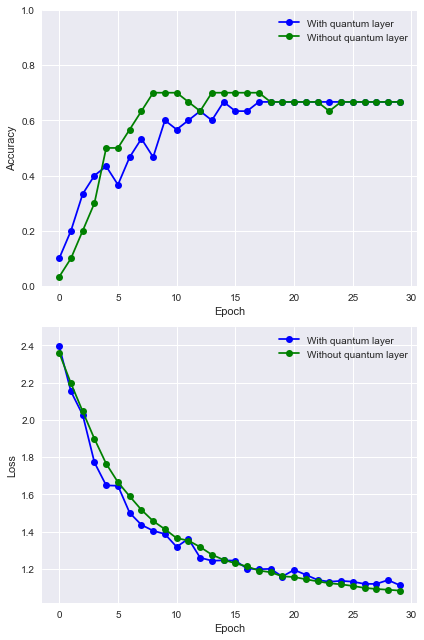

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()